# Version Control
- V00: follow F.Chollet [使用非常少的数据构建强大的图像分类模型](https://github.com/ictar/python-doc/blob/master/Machine%20Learning/使用非常少的数据构建强大的图像分类模型.md) & [秉叡](https://drive.google.com/open?id=1-wHQCF9mkj_3CLewJ9MbtlT9MhWS1fw5)
- V01
    - 增加視覺化 func & save model/png
- V02
    - 以 grayscale 訓練模型

# CODE

In [0]:
import os, glob, csv, math
from datetime import datetime
# from random import shuffle
# from collections import Counter
# import h5py, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam, RMSprop

# 顯示每一項 var.  的 output
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [35]:
# 設定路徑
from google.colab import drive
drive.mount('/content/gdrive')
# path_wrt = '/content/gdrive/My Drive/projects/oil_king/rec'
path_wrt = '/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/alv/model_rec'
path_train = '/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/alv/train0'
path_test = '/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/確定使用圖片(含LABEL)'
# path_wrt = 'C:\\Users\\Users\\Google 雲端硬碟\\projects\\oil_king'
# path_train = 'D:\\OilKing\\train0130'
# path_wrt = '/Users/yuenlungliu/GoogleDrive_iii/projects/oil_king/rec'
# path_train = '/Users/yuenlungliu/GoogleDrive_iii/projects/oil_king/train'

os.chdir(path_wrt)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# model = Sequential(...)
# model.compile(
#     loss / optimizer / callbacks = ...
# )
# model.fit_generator(
#     generator = ImageDataGenerator().flow(X, y)
# )

In [41]:
# 生成 data augmentation 的 generator
datagen = ImageDataGenerator(
            validation_split=0.2,
            rescale=1./255,
            rotation_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
)

img_size = (224,224)
batch_size = 32
color_mode = 'grayscale' # Keras : One of "grayscale", "rgb", "rgba"
if color_mode=="grayscale":
    img_channels = 1
else:
    img_channels = len(color_mode)
input_shp = tuple(list(img_size)+[img_channels]) # example: (224, 224, 1/3/4);
input_shp3 = tuple(list(img_size)+[3])           # example: (224, 224, 3); imagenet 的 weights 只接受 (x, x, 3)
print("train/validation: ", input_shp)

trn_generator = datagen.flow_from_directory(
                    path_train, target_size=img_size, batch_size=batch_size,
                    #save_to_dir=path_wrt +"/aug", #是否保存 real-time 處理過的圖片
                    save_prefix="trn+",
                    color_mode=color_mode,
                    subset="training"
)
val_generator = datagen.flow_from_directory(
                    path_train, target_size=img_size, batch_size=batch_size,
                    #save_to_dir=path_wrt +"/aug",
                    save_prefix="val+",
                    color_mode=color_mode,
                    subset="validation",
)

# 設定 labels
# 方法1:
# map_labels = {
#     0: 'fold',      #摺皺
#     1: 'fault',     #斷層
#     2: 'anticline', #背斜: subclass of folds
# }


# 方法2:
# print(os.listdir(path_train))
i = 0
map_labels = {}
for path in sorted(os.listdir(path_train)):
    if os.path.isdir(path_train+"/"+path):
        map_labels[i] = path
        i+=1
print(map_labels)

num_labels = len(map_labels)

train/validation:  (224, 224, 1)
Found 712 images belonging to 4 classes.
Found 178 images belonging to 4 classes.
{0: 'anticline', 1: 'fault', 2: 'fold', 3: 'wo'}


In [0]:
# # 展示 showcase of ImageDataGenerator
# path_train_flat = '/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/確定使用圖片(含LABEL)'
# img = load_img(path_train_flat +"/" + os.listdir(path_train_flat)[0])  # this is a PIL image

# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow(x, batch_size=1,
#                           save_to_dir= path_wrt + '/datagen_samples',
#                           save_prefix='show01',
#                           save_format='jpg',
#                          ):
#     i += 1
#     if i > 10:
#         break  # otherwise the generator would loop indefinitely

In [0]:
# 定義訓練模型


In [42]:
# model_base
#-------------------
# 0: 簡單 CNN model
# https://github.com/ictar/python-doc/blob/master/Machine%20Learning/使用非常少的数据构建强大的图像分类模型.md
# base_0 = Sequential()
# base_0.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shp))
# base_0.add(MaxPooling2D(pool_size=(2, 2)))

# base_0.add(Conv2D(32, (3,3), padding='same', activation='relu'))
# base_0.add(MaxPooling2D(pool_size=(2, 2)))

# base_0.add(Conv2D(64, (3,3), padding='same', activation='relu'))
# base_0.add(MaxPooling2D(pool_size=(2, 2)))
# the model so far outputs 3D feature maps (height, width, features)

# 1: 模仿 VGG16 的 CNN model
# base_1 = Sequential()
# base_1.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shp))
# base_1.add(Conv2D(64, (3,3), padding='same', activation='relu'))
# base_1.add(MaxPooling2D(pool_size=(2, 2)))

# base_1.add(Conv2D(128, (3,3), padding='same', activation='relu'))
# base_1.add(Conv2D(128, (3,3), padding='same', activation='relu'))
# base_1.add(MaxPooling2D(pool_size=(2, 2)))

# base_1.add(Conv2D(256, (3,3), padding='same', activation='relu'))
# base_1.add(Conv2D(256, (3,3), padding='same', activation='relu'))
# base_1.add(MaxPooling2D(pool_size=(2, 2)))

# base_1.add(Conv2D(512, (3,3), padding='same', activation='relu'))
# base_1.add(Conv2D(512, (3,3), padding='same', activation='relu'))
# base_1.add(MaxPooling2D(pool_size=(2, 2)))

# base_1.add(Conv2D(512, (3,3), padding='same', activation='relu'))
# base_1.add(Conv2D(512, (3,3), padding='same', activation='relu'))
# base_1.add(MaxPooling2D(pool_size=(2, 2)))

# 2: Keras Applications
base_vgg16 = keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet', input_shape=input_shp3, classes=num_labels)
base_resnet = keras.applications.resnet50.ResNet50(
                include_top=False, weights='imagenet', input_shape=input_shp3, classes=num_labels)
base_mobilenet = keras.applications.mobilenet.MobileNet(
                include_top=False, weights='imagenet', input_shape=input_shp3, classes=num_labels)

# model_top
#-------------------
# 0: 簡單 CNN model
# https://github.com/ictar/python-doc/blob/master/Machine%20Learning/使用非常少的数据构建强大的图像分类模型.md
# top_0 = Sequential()
# top_0.add(Flatten())
# top_0.add(Dense(64, activation='relu'))
# top_0.add(Dropout(0.5))
# top_0.add(Dense(num_labels, activation='softmax'))

# 1: BatchNormalization
top_1 = Sequential()
top_1.add(Flatten())
top_1.add(BatchNormalization())
top_1.add(Dense(64, activation='relu'))
top_1.add(BatchNormalization())
top_1.add(Dense(num_labels, activation='softmax'))

print("\nLoading models......Done!")

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



Loading models......Done!


In [22]:
# callbacks
#------------
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
filename = datetime.now().isoformat(timespec='minutes') .replace(":","")
chkpoint = ModelCheckpoint(filename+"_.h5", 
                       monitor='val_loss', verbose=1, 
                       save_best_only=True,
)
reduceLR = ReduceLROnPlateau(
                    patience=3, factor=0.5, min_lr=0.00001, #cooldown=5, 
                    monitor='val_loss', mode='auto', #epsilon=0.00001,
                    verbose=1, 
)
early = EarlyStopping(
                patience=6, 
                monitor="val_loss", mode="auto", 
                verbose=1,
)
callbacks = [chkpoint, reduceLR, early]

# compile & fit
#-----------------
base = base_mobilenet; base.trainable=False
top = top_1

model = Sequential()
if color_mode=='grayscale':
    model.add(Conv2D(3, (1,1), padding='same', activation='relu', input_shape=input_shp))
    model.trainable=False
model.add(base)
model.add(top)

model.compile(
        loss='categorical_crossentropy',
        optimizer='Adam',
        metrics=['accuracy']
)
stepX = 2
history = model.fit_generator(
                    trn_generator,
                    validation_data=val_generator,
                    epochs=30,
                    steps_per_epoch=len(trn_generator)*stepX,
                    validation_steps=len(val_generator)*stepX,
                    callbacks=callbacks
)

Epoch 1/30
46/46 [==============================] - 28s 609ms/step - loss: 0.7373 - acc: 0.7575 - val_loss: 0.8572 - val_acc: 0.6517

Epoch 00001: val_loss improved from inf to 0.85719, saving model to 2019-02-10T1241_.h5
Epoch 2/30
46/46 [==============================] - 16s 340ms/step - loss: 0.3623 - acc: 0.8648 - val_loss: 0.8660 - val_acc: 0.6629

Epoch 00002: val_loss did not improve from 0.85719
Epoch 3/30
46/46 [==============================] - 21s 448ms/step - loss: 0.2659 - acc: 0.9083 - val_loss: 0.9669 - val_acc: 0.6601

Epoch 00003: val_loss did not improve from 0.85719
Epoch 4/30
46/46 [==============================] - 22s 474ms/step - loss: 0.2270 - acc: 0.9206 - val_loss: 0.7801 - val_acc: 0.7107

Epoch 00004: val_loss improved from 0.85719 to 0.78013, saving model to 2019-02-10T1241_.h5
Epoch 5/30
46/46 [==============================] - 21s 453ms/step - loss: 0.2124 - acc: 0.9307 - val_loss: 0.9790 - val_acc: 0.6404

Epoch 00005: val_loss did not improve from 0.780

In [40]:
# base.summary()
# top.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 3)       6         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
sequential_6 (Sequential)    (None, 4)                 3412548   
Total params: 6,641,418
Trainable params: 3,312,074
Non-trainable params: 3,329,344
_________________________________________________________________


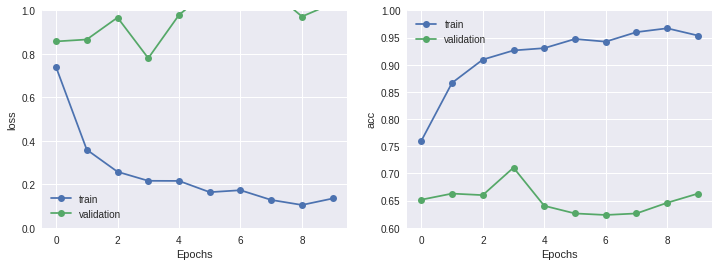

In [24]:
 # 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plot_train_history(history, 'loss','val_loss'); plt.ylim((0,1))
plt.subplot(1,2,2); plot_train_history(history, 'acc','val_acc'); plt.ylim((0.6,1))
plt.gcf().savefig(filename+"_fit.png")
plt.show();

In [0]:
# from keras.models import load_model
# model_recs = glob.glob("*.h5")
# filename = model_recs[1].replace("_.h5","")
# model = load_model(filename + "_.h5")

# print(model.summary())
# print(filename)

Found 890 images belonging to 4 classes.
(890, 224, 224, 1)
890/890 [==============================] - 9s 10ms/step


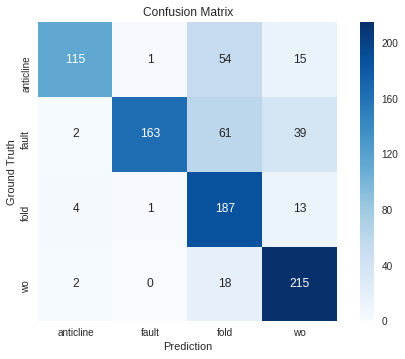

In [25]:
# validation 結果視覺化
#---------------------
# 從 _generator 取出 X, y
idg0 = ImageDataGenerator(rescale=1./255,) # 空的 ImageDataGenerator --> 不做 data augmentation
generator = idg0.flow_from_directory(
                    path_train, target_size=img_size, batch_size=batch_size,
                    #subset="validation", #把整個 train 下去做 validate
                    shuffle=False,            #不shuffle 以取得檔名
)

img_names = generator.filenames
X, y_true = [], []
for i in range(len(generator)):
    X_add, y_add = next(generator)
    X.extend(X_add)
    y_true.extend(y_add)    
    #print("i = ", i, X_add.shape, y_add.shape, len(X_val))

X, y_true = np.array(X), np.array(y_true)
label_true = np.argmax(y_true, axis=1) # y as One-Hot-Encoding; label as Label-Encoding
# 處理 X 的灰階問題
if color_mode=='grayscale':
    tmp = []
    for i in range(len(X)):
        #X[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
        tmp.append(cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY).reshape(input_shp))
    X = np.array(tmp)
print(X.shape)

# 給出 prediction
y_pred = model.predict(X, verbose=1)
label_pred = np.argmax(y_pred, axis=1)

# 分類 Report
# print("\n",
#         classification_report(np.argmax(y_true, axis=1),
#                                       np.argmax(y_pred, axis=1),
#                                       target_names = map_labels.values(),
#                                       )
#     )

# 混淆矩陣 Confusion Matrix
df = pd.DataFrame(confusion_matrix(label_true, label_pred), 
                            index=map_labels.values(),
                            columns=map_labels.values()
                            )
sns.heatmap(df, annot=True, square=True, fmt='.0f', cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.savefig(filename+"_cm.png")
plt.show();

In [32]:
# 顯示預測錯誤的圖片
err_X = X[label_true != label_pred]
err_y = y_pred[label_true != label_pred]
err_ans = label_true[label_true != label_pred]
# err_label_pred = label_pred[label_true != label_pred]
err_imgnames = np.array(img_names)[label_true != label_pred]

# cv2.putText 的 參數
origin = (10, 140)
line_h = 20  

for i in np.unique(err_ans):
    j_total = len(err_ans[err_ans==i])
    ncols =4
    nrows = math.ceil(j_total / ncols)
    
    fig_width = 15
    fig = plt.figure(figsize=(fig_width, fig_width/ncols*nrows))
    #fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(fig_width, fig_width/ncols*nrows))
    #fig.suptitle("Truth = [" + map_labels[i] + "]", fontsize=16, fontweight='bold')
    
    for j in range(j_total):
        ax = plt.subplot(nrows, ncols, j+1)
        
        # 擺入預測機率
        ratios = err_y[err_ans==i][j].tolist()
        text=[]
        for k in range(len(ratios)):
            text.append( f'{ratios[k] :.0%}' + " " + map_labels[k])
        #img = array_to_img(err_X[err_ans==i][j]); #cv2.putText 要用 ndarray 當 input
        img = err_X[err_ans==i][j]
        for k in range(len(text)):
            cv2.putText(img, text[k], (origin[0], origin[1] + k *line_h),
                              fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                              fontScale=0.7,
                              color=(0/255., 200 /255., 200 /255.),
                              thickness=2,
                              lineType=cv2.LINE_AA,
            )
        
        # 擺入檔名
        text_fn = err_imgnames[err_ans==i][j]
        cv2.putText(img, text_fn, (origin[0], origin[1] + len(text) *line_h),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                          fontScale=0.7,
                          color=(100 /255., 200 /255., 0 /255.),
                          thickness=2,
                          lineType=cv2.LINE_AA,
        )
        
        # 處理灰階 shape (224,224,1) --> (224,224)
        if color_mode=='grayscale':
            img = img.reshape(img_size)
        
        aximg = plt.imshow(img)
        ax.grid(None)
        ax.axis('off')
    plt.gcf().savefig(filename +'_err_'  +map_labels[i] + '.png')
    plt.show();

Output hidden; open in https://colab.research.google.com to view.